In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

import os

np.random.seed(453453)


import json
import json_tricks
import checkpoints
from checkpoints import np_string

from stability_utils import get_expected_mutual_info, get_fowlkes_mallows_score

# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

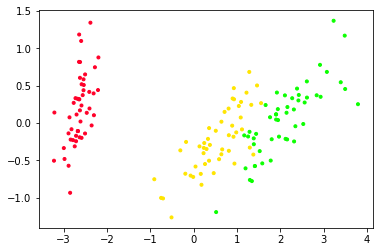

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [8]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior parameters

In [9]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)


In [10]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Define model

In [11]:
k_approx = 5

In [12]:
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, \
            k_approx, prior_params, gh_deg,
            use_logitnormal_sticks=True,
            use_bnp_prior = False)


# Initialize

In [13]:
print('running k-means init')
n_kmeans_init = 50
init_global_free_param = \
        model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

running k-means init


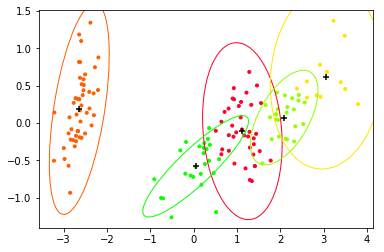

In [14]:
# Check initialization
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

# Optimize

In [15]:
print('running Newton steps: ')
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500)

t_newton = time.time() - t0
print('done optimizing. Optim time: {}'.format(t_newton))


running Newton steps: 
Iter: 0	 RMSE: 6.630666403870832	 Objective: -496.7470327635352
Iter: 10	 RMSE: 6.69115882885725	 Objective: -521.7267105364136
Iter: 20	 RMSE: 6.783602110852499	 Objective: -542.9190733441917
Iter: 30	 RMSE: 6.711208154851612	 Objective: -553.4567113893371
Iter: 40	 RMSE: 6.7820859504529665	 Objective: -556.6712623052164
Iter: 50	 RMSE: 6.767029512045667	 Objective: -557.2983828873648
Iter: 60	 RMSE: 6.76779254911384	 Objective: -557.4007464032327
Iter: 70	 RMSE: 6.764091687453438	 Objective: -557.4094245326052
Iter: 80	 RMSE: 6.764097506251105	 Objective: -557.4094246660782
Optimization terminated successfully.
         Current function value: -557.409425
         Iterations: 69
         Function evaluations: 81
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: -557.409425
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff 

In [16]:
newton_results = deepcopy(model)

In [17]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

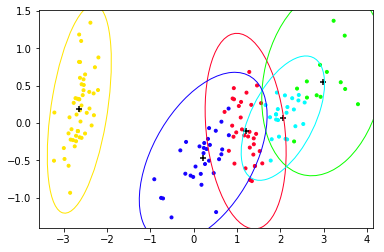

In [18]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
    
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

# Get bootstrap sample and re-optimize

In [19]:
model.global_vb_params.set_free(best_param)

In [20]:
model.use_weights = True
samples_indx = np.random.choice(model.n_obs,
                        size = model.n_obs,
                        replace = True)
samples_indx, sample_indx_counts = np.unique(samples_indx,
                                            return_counts = True)

model.weights = np.zeros((model.n_obs, 1))
model.weights[samples_indx] = sample_indx_counts[:, None]


# model.weights = np.ones((model.n_obs, 1))
# model.weights[1] = 0


In [21]:
print('running Newton steps: ')
t0 = time.time()
boot_best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(best_param,
            init_max_iter=100,
            final_max_iter=500)

t_newton = time.time() - t0
print('done optimizing. Optim time: {}'.format(t_newton))


running Newton steps: 
Iter: 0	 RMSE: 6.764097510028748	 Objective: -532.3567468778633
Iter: 10	 RMSE: 6.868345959616493	 Objective: -543.831680634765
Iter: 20	 RMSE: 6.9765869334383455	 Objective: -549.70015074392
Iter: 30	 RMSE: 6.930788896711801	 Objective: -552.2162784871707
Iter: 40	 RMSE: 6.880583273838648	 Objective: -553.0853505006235
Iter: 50	 RMSE: 6.8878797378101515	 Objective: -553.2539685515842
Iter: 60	 RMSE: 6.892421196654096	 Objective: -553.3129377784269
Iter: 70	 RMSE: 6.89275059021583	 Objective: -553.3143460717095
Optimization terminated successfully.
         Current function value: -553.314347
         Iterations: 68
         Function evaluations: 80
         Gradient evaluations: 80
Iter: 80	 RMSE: 6.8927335919289066	 Objective: -553.3143465883437
Iter: 90	 RMSE: 6.8927335891361174	 Objective: -553.3143465883437
         Current function value: -553.314347
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 2
         Hessian 

In [22]:
np.max(np.abs(boot_best_param - best_param))

1.3029940953520878

In [23]:
model.set_optimal_z()

In [24]:
model_boot = deepcopy(model)

# Compare against LRVB

In [25]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)
model.use_weights = False

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [26]:
full_params = newton_results.global_vb_params.get_free()
boot_params = model_boot.global_vb_params.get_free()

print(np.max(np.abs(boot_params - full_params)))

1.3029940953520878


In [27]:
lr_params = np.dot(linear_sens.data_sens_mat, \
                   model_boot.weights - np.ones((model.n_obs, 1))).flatten() + full_params

In [28]:
def comparison_plot(x, y): 
    plt.plot(x, y, 'r+')
    plt.plot(x, x)

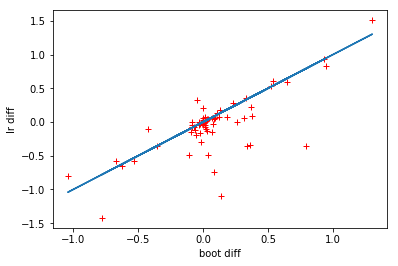

In [29]:
comparison_plot(boot_params - full_params, lr_params - full_params)
plt.xlabel('boot diff')
plt.ylabel('lr diff')

In [30]:
e_z_full = newton_results.vb_params['e_z'].get()
e_z_boot = model_boot.vb_params['e_z'].get()

model.set_from_global_free_par(lr_params)
model.set_optimal_z()
e_z_lr = model.vb_params['e_z'].get()

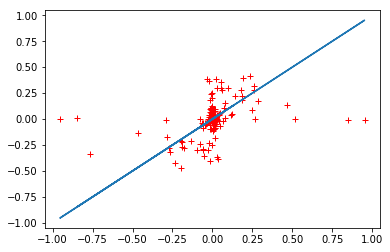

In [31]:
comparison_plot((e_z_boot - e_z_full).flatten(), (e_z_lr - e_z_full).flatten())

In [32]:
get_fowlkes_mallows_score(e_z_full, e_z_boot)

0.972628924491268

In [33]:
get_fowlkes_mallows_score(e_z_full, e_z_lr)

0.9803842194779476

In [34]:
get_expected_mutual_info(e_z_full, e_z_boot)

0.8009226830919981

In [35]:
get_expected_mutual_info(e_z_full, e_z_lr)

0.7823533779922834